In [1]:
# Imports
import numpy as np
import copy as cp

# Mujoco
import mujoco
import mujoco_viewer

# Controller functions
from control.controllers.mppi_locomanipulation import MPPI_box_push

from utils.tasks import get_task
from utils.transforms import batch_world_to_local_velocity

# Visualization
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt

## Choose task
* `'push_box'`

In [2]:
# Task
task = 'push_box'
task_data = get_task(task)
model_path = task_data['sim_path']

In [3]:
# Model visualizer
model_sim = mujoco.MjModel.from_xml_path(model_path)
dt_sim = 0.01
model_sim.opt.timestep = dt_sim
data_sim = mujoco.MjData(model_sim)
viewer = mujoco_viewer.MujocoViewer(model_sim, data_sim, 'offscreen')

In [4]:
# Reset robot (keyframes are defined in the xml)
mujoco.mj_resetDataKeyframe(model_sim, data_sim, 0) # stand position
mujoco.mj_forward(model_sim, data_sim)
q_init = cp.deepcopy(data_sim.qpos) # save reference pose
v_init = cp.deepcopy(data_sim.qvel) # save reference pose
print("Configuration: {}".format(q_init)) # save reference pose

Configuration: [ 1.    0.    0.15  1.    0.    0.    0.    0.    0.    0.26  1.    0.
  0.    0.    0.    0.9  -1.8   0.    0.9  -1.8   0.    0.9  -1.8   0.
  0.9  -1.8 ]


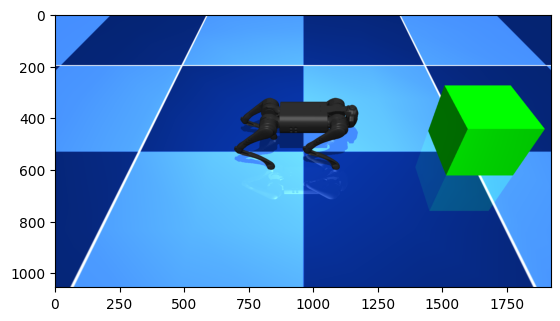

In [5]:
img = viewer.read_pixels()
plt.imshow(img)

In [6]:
# Initialize controller
controller = MPPI_box_push(task=task)
controller.internal_ref = True
controller.reset_planner()

Task:  push_box
Initial goal 0: [0, 0.0, 0.27]
Initial gait in_place


In [7]:
q_curr = cp.deepcopy(data_sim.qpos) # save reference pose
v_curr = cp.deepcopy(data_sim.qvel) # save reference pose
x = np.concatenate([q_curr, v_curr])

In [8]:
# Set desired box location
controller.x_box_ref[0] = 2 # x location in world coordinates (current forward direction)
controller.x_box_ref[1] = 1 # y location in world coordinates (current forward direction)

In [9]:
# Set simulation time
tfinal = 26
tvec = np.linspace(0,tfinal,int(np.ceil(tfinal/dt_sim))+1)

In [10]:
mujoco.mj_resetDataKeyframe(model_sim, data_sim, 0)
mujoco.mj_forward(model_sim, data_sim)

In [11]:
viewer.cam.distance = 3.5
viewer.cam.lookat[:] = [1,1,0]

In [12]:
 viewer.add_marker(
         pos=controller.x_box_ref[:3]*1,         # Position of the marker
         size=[0.15, 0.15, 0.15],     # Size of the sphere
         rgba=[1, 1, 0, 1],           # Color of the sphere (red)
         type=mujoco.mjtGeom.mjGEOM_SPHERE, # Specify that this is a sphere
         label=""
     )
 viewer.add_marker(
         pos=controller.body_ref[:3]*1,         # Position of the marker
         size=[0.15, 0.15, 0.15],     # Size of the sphere
         rgba=[1, 0, 1, 1],           # Color of the sphere (red)
         type=mujoco.mjtGeom.mjGEOM_SPHERE, # Specify that this is a sphere
         label=""
     )

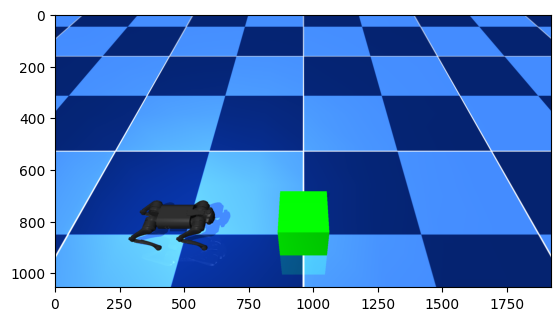

In [13]:
img = viewer.read_pixels()
plt.imshow(img)

In [14]:
q_curr = cp.deepcopy(data_sim.qpos) # save reference pose
v_curr = cp.deepcopy(data_sim.qvel) # save reference pose
x = np.concatenate([q_curr, v_curr])

In [15]:
%%time
# Run simulation
anim_imgs = []
sim_inputs = []
x_states = []
error_history = []
max_cost_history = []
min_cost_history = []
cost_norm_history = []
num_iter_per_goal = np.zeros(len(controller.goal_pos))
for ticks, ti in enumerate(tvec):
    q_curr = cp.deepcopy(data_sim.qpos) # save reference pose
    v_curr = cp.deepcopy(data_sim.qvel) # save reference pose
    x = np.concatenate([q_curr, v_curr])
    
    if ticks%1 == 0:
        u_joints, cost_info = controller.update(x)  
        max_cost_history.append(cost_info['max_cost'])
        min_cost_history.append(cost_info['min_cost'])
        cost_norm_history.append(np.linalg.norm(cost_info['max_cost'] - cost_info['min_cost']))  
        
    data_sim.ctrl[:] = u_joints
    mujoco.mj_step(model_sim, data_sim)
    mujoco.mj_forward(model_sim, data_sim)

    error = np.linalg.norm(np.array(controller.body_ref[:3]) - np.array(data_sim.qpos[7:10]))
    error_history.append(error)
    viewer.add_marker(
         pos=controller.body_ref[:3]*1,         # Position of the marker
         size=[0.15, 0.15, 0.15],     # Size of the sphere
         rgba=[1, 0, 1, 1],           # Color of the sphere (red)
         type=mujoco.mjtGeom.mjGEOM_SPHERE, # Specify that this is a sphere
         label=""
    )
    
    viewer.add_marker(
         pos=controller.x_box_ref[:3]*1,         # Position of the marker
         size=[0.15, 0.15, 0.15],     # Size of the sphere
         rgba=[1, 1, 0, 1],           # Color of the sphere (red)
         type=mujoco.mjtGeom.mjGEOM_SPHERE, # Specify that this is a sphere
         label=""
     )
    if error < 0.1:
        controller.next_goal()

    if ticks % 2 == 1:
        img = viewer.read_pixels()
        anim_imgs.append(img)
    sim_inputs.append(u_joints)
    x_states.append(x)

still working...
still working...
CPU times: total: 22 s
Wall time: 1min 1s


In [16]:
x_states_np = np.array(x_states)

In [17]:
box_state = np.zeros((tvec.shape[0], 13))
robot_state = np.zeros((tvec.shape[0], 37))

In [18]:
box_state[:,:7] = x_states_np[:,:7]
robot_state[:,:19] = x_states_np[:,7:26]
box_state[:,7:] = x_states_np[:,26:32]
robot_state[:,19:] = x_states_np[:,32:]

In [19]:
controller.sample_type

'bezier'

## Box state

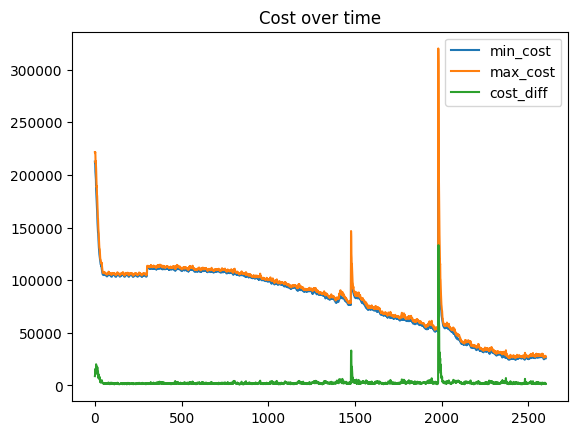

In [20]:
plt.plot(min_cost_history, label="min_cost")
plt.plot(max_cost_history, label='max_cost')
plt.plot(cost_norm_history, label= 'cost_diff')
plt.title("Cost over time")
plt.legend()

Text(0.5, 1.0, 'Error Over Time')

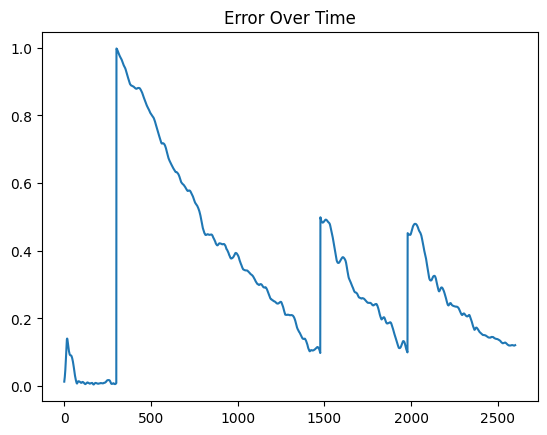

In [21]:
plt.plot(error_history)
plt.title("Error Over Time")

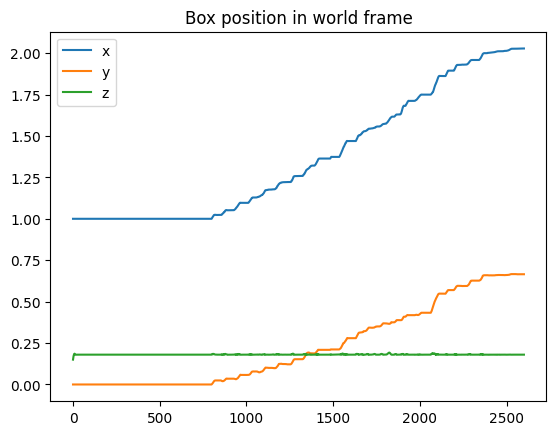

In [22]:
plt.plot(box_state[:,:3], label=["x", "y", "z"])
plt.title("Box position in world frame")
plt.legend()

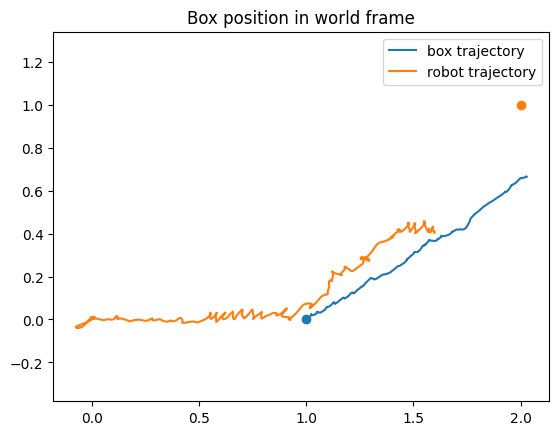

In [23]:
plt.plot(box_state[:,0], box_state[:,1], label="box trajectory")
plt.scatter(box_state[0,0], box_state[0,1])
plt.scatter(controller.x_box_ref[0], controller.x_box_ref[1])

plt.plot(robot_state[:,0], robot_state[:,1],label="robot trajectory")
plt.axis("equal")
plt.title("Box position in world frame")
plt.legend()

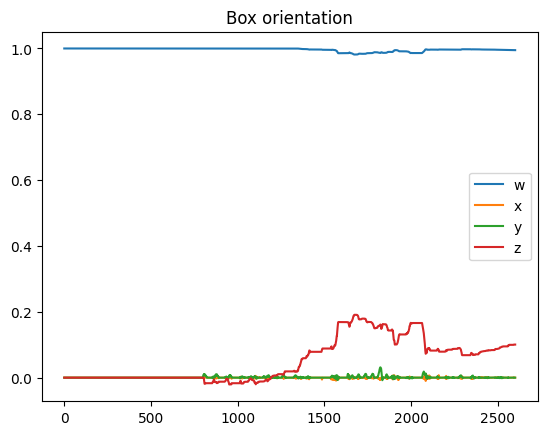

In [24]:
plt.plot(box_state[:,3:7], label=["w", "x", "y", "z"])
plt.title("Box orientation")
plt.legend()

## Robot state

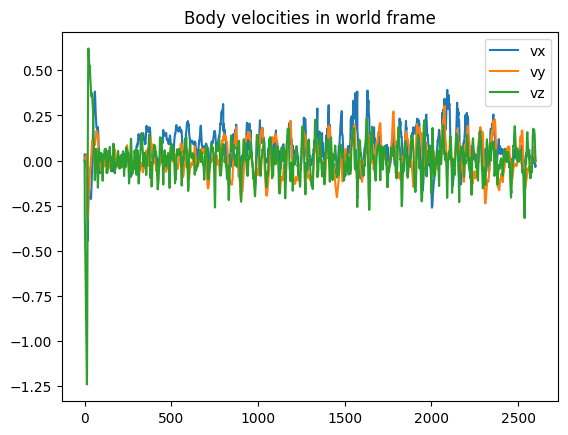

In [25]:
orientations = robot_state[:,3:7]
velocities = robot_state[:,19:22]
velocities_trans = batch_world_to_local_velocity(orientations, velocities)

plt.plot(velocities_trans, label=["vx", "vy", "vz"])
plt.title("Body velocities in world frame")
plt.legend()

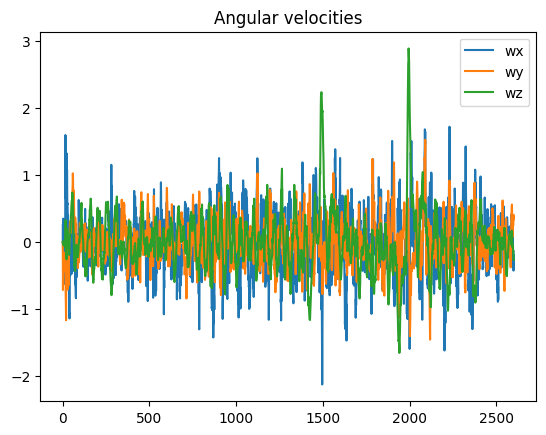

In [26]:
angular_velocities = robot_state[:,22:25]
plt.plot(angular_velocities, label=["wx", "wy", "wz"])
plt.title("Angular velocities")
plt.legend()

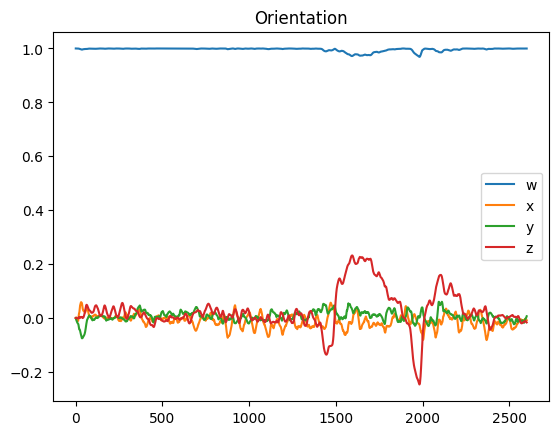

In [27]:
plt.plot(orientations, label=["w", "x", "y", "z"])
plt.title("Orientation")
plt.legend()

Text(0.5, 1.0, 'Joint angles FR leg')

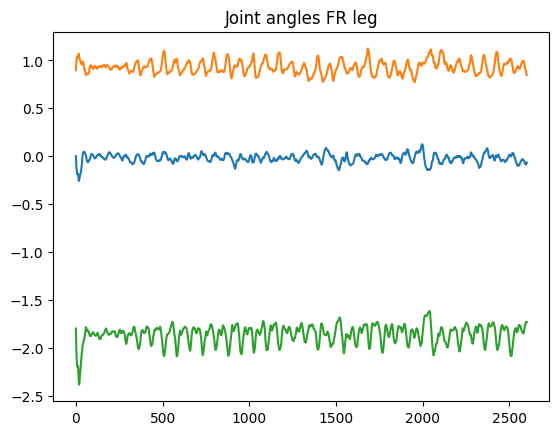

In [28]:
plt.plot(robot_state[:,7:10], label=["hip","thigh","calf"])
plt.title("Joint angles FR leg")

Text(0.5, 1.0, 'Joint angles FL leg')

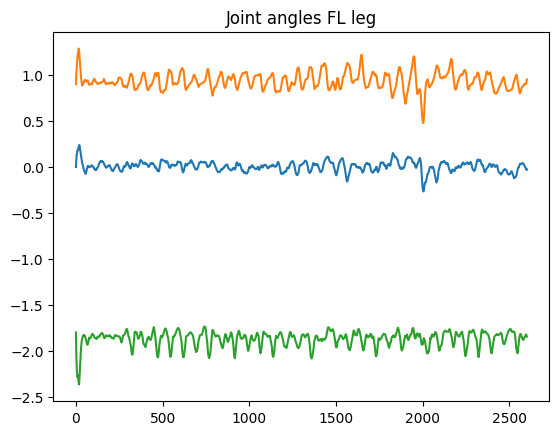

In [29]:
plt.plot(robot_state[:,10:13], label=["hip","thigh","calf"])
plt.title("Joint angles FL leg")

Text(0.5, 1.0, 'Joint angles RR leg')

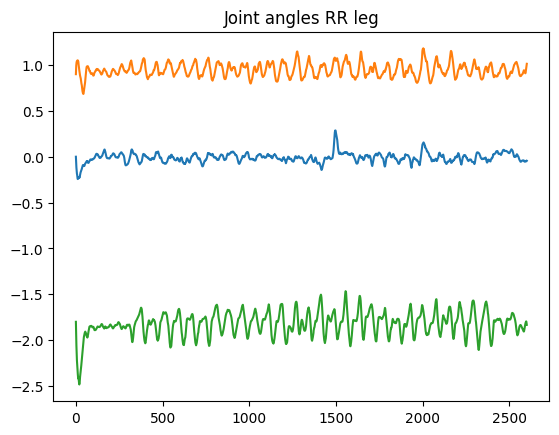

In [30]:
plt.plot(robot_state[:,13:16], label=["hip","thigh","calf"])
plt.title("Joint angles RR leg")

Text(0.5, 1.0, 'Joint angles RL leg')

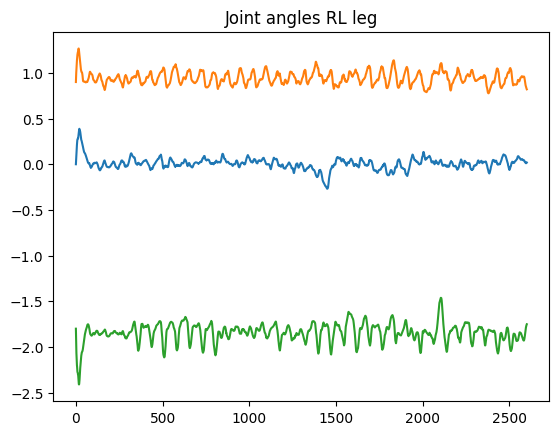

In [31]:
plt.plot(robot_state[:,16:19], label=["hip","thigh","calf"])
plt.title("Joint angles RL leg")

In [32]:
sim_inputs_np = np.array(sim_inputs)

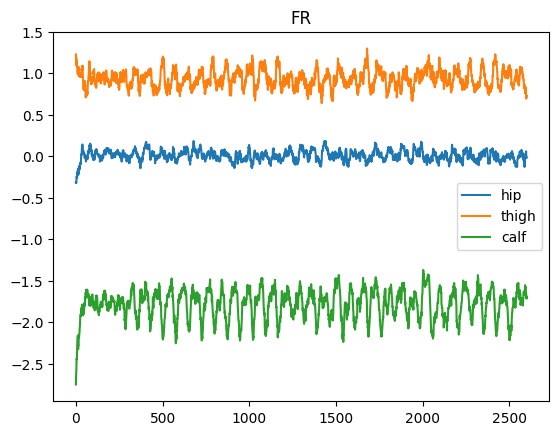

In [33]:
plt.plot(sim_inputs_np[:,0:3], label=["hip", "thigh", "calf"])
plt.title("FR")
plt.legend()

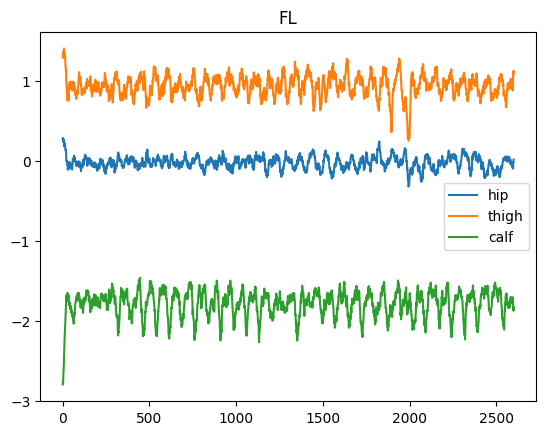

In [34]:
plt.plot(sim_inputs_np[:,3:6], label=["hip", "thigh", "calf"])
plt.title("FL")
plt.legend()

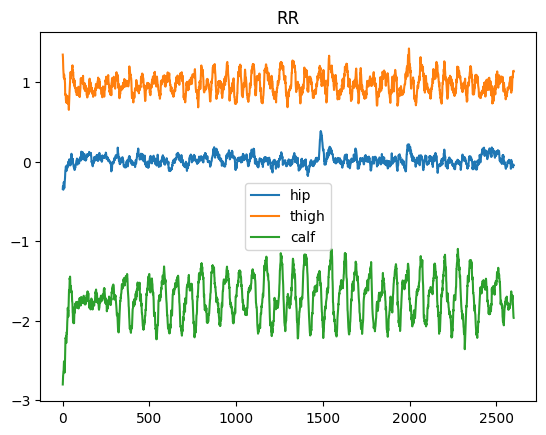

In [35]:
plt.plot(sim_inputs_np[:,6:9], label=["hip", "thigh", "calf"])
plt.title("RR")
plt.legend()

## Animation

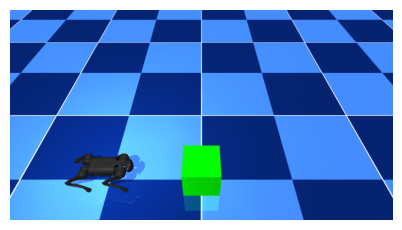

In [36]:
# Get the resolution of the images
image_height, image_width = anim_imgs[0].shape[:2]

# Set the figure size to match the image resolution
fig, ax = plt.subplots(figsize=(image_width / 500, image_height / 500), dpi=100)
skip_frames = 10
interval = dt_sim*1000*skip_frames
# Remove the white border by setting margins and padding to zero
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.set_position([0, 0, 1, 1])

def animate(i):
    ax.clear()
    ax.imshow(anim_imgs[i * skip_frames])  # Display the image, skipping frames
    ax.axis('off')

# Create animation, considering the reduced frame rate due to skipped frames
ani = FuncAnimation(fig, animate, frames=len(anim_imgs) // skip_frames, interval=interval)  # 50 ms for 20 Hz

# Display the animation
HTML(ani.to_jshtml())

In [ ]:
from PIL import Image
import numpy as np
import cv2

# Get the resolution of the images
image_height, image_width = anim_imgs[0].shape[:2]

# List to store frames as PIL images
gif_frames = []

skip_frames = 10  # Adjust as needed

# Convert frames to PIL Image format
for i in range(0, len(anim_imgs), skip_frames):
    frame = anim_imgs[i]
    # Convert the frame to 8-bit unsigned integer if needed (OpenCV compatibility)
    if frame.dtype != np.uint8:
        frame = (frame * 255).astype(np.uint8)
    
    # Convert BGR to RGB (Pillow expects RGB format)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame)
    
    # Append to gif frames list
    gif_frames.append(pil_image)

# Save the frames as a GIF
output_filename = 'push_box_bezier_k_4.gif'
gif_frames[0].save(
    output_filename,
    save_all=True,
    append_images=gif_frames[1:],
    duration=1000 / 20,  # Frame duration in milliseconds (20 fps)
    loop=0  # 0 means the GIF will loop indefinitely
)

print(f"GIF saved as {output_filename}")
